## Inference with the fitted appearance descriptors

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os
import sys
import cv2
import yaml
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('')+'/src')

from dataloaders.loaders.utils import make_dataloader

from models.nstack import nstack_from_statedict, PointNeuralTex, NeuralStack
from models.pcd_converter import PCDConverter
from models.pcd_renderer import Renderer

from appearance.infer import infer_pid
from appearance.utils import to_img, show_axes

from utils.utils import load_module
from utils.common import dict2device, itt, tti, to_sigm

os.environ["DEBUG"] = ''

### Style subject and models setup

In [2]:
!ls out/appearance/psp/male-3-casual

'08-30_02-32___config_name^appearance+psp_male-3-casual'
'08-30_03-01___config_name^appearance+psp_male-3-casual'
'08-30_03-06___config_name^appearance+psp_male-3-casual'
'08-30_15-43___config_name^appearance+psp_male-3-casual'


In [3]:
# set the subject to take the outfit style from
style_pid = 'male-3-casual'
experiment_name = <INSERT NAME OF AN EXPERIMENT FOLDER FROM THE OUTPUT OF THE PREVIOUS CELL>
experiment_path = f'out/appearance/psp/{style_pid}/{experiment_name}'
ep = 79

# appearance model checkpoints setup
model_path = os.path.join(experiment_path, 'checkpoints', f'model0_{ep:04d}.pth')
ntex_path = os.path.join(experiment_path, 'checkpoints', f'ntex0_{ep:04d}.pth')
if not os.path.exists(model_path):
    model_path = os.path.join(experiment_path, f'model0_{ep:04d}.pth')
    ntex_path = os.path.join(experiment_path, f'ntex0_{ep:04d}.pth')

model_cp = torch.load(model_path)
ntex_cp = torch.load(ntex_path)
args = model_cp['args']
device = 'cuda:0'

args.num_workers = 0

# point cloud converter
converter = PCDConverter(device)

# outfit point cloud prediction network
draping_network = load_module('models', 'draping_network_wrapper').Wrapper.get_net(args)
print(draping_network.glo_stack)

# learned outfit codes
outfit_codes_file = f'out/outfit_code/outfit_codes_psp.pkl'
outfit_codes_dict = pickle.load(open(outfit_codes_file, 'rb'))
print('\n> Outfit codes dict:', outfit_codes_dict)

outfit_code = torch.from_numpy(outfit_codes_dict[style_pid]).to(device)
print(f'\n> Current style: pid={style_pid}, shape={outfit_code.shape}')

# learned per-point neural descriptors
ndesc_stack = nstack_from_statedict(lambda: PointNeuralTex(args.ntex_channels, args.pcd_size), ntex_cp)
print(ndesc_stack)

# differentiable rasterizer
args.visibility_thr= 2e-3
renderer = Renderer(args.imsize, args.imsize, args.ntex_channels, device=args.device, 
                    visibility_thr=args.visibility_thr, scale=1, radius=2)
renderer_flood = Renderer(args.imsize, args.imsize, args.ntex_channels, device=args.device, 
                          visibility_thr=args.visibility_thr, scale=1, radius=6)

# neural rendering network
generator = load_module('generators', args.generator).Wrapper.get_net(args)
generator.load_state_dict(model_cp['generator'])

['male-1-casual', 'male-3-casual']

> Loading the draping network model from checkpoints/draping_network_90_epochs.pth...
NeuralStack(
  (textures): ModuleList(
    (0): GLOVector()
  )
  (pid2ntid): ParameterDict(  (male-3-casual): Parameter containing: [torch.cuda.LongTensor of size 1 (GPU 0)])
)

> Outfit codes dict: {'male-1-casual': array([ 0.0809941 , -0.43872824,  0.20763539,  0.4111563 , -0.7133698 ,
       -0.07154377, -0.23637031, -0.2811662 ], dtype=float32), 'male-3-casual': array([-0.5855567 , -0.19764575,  0.06156886,  0.33132124,  0.36146787,
       -0.11059047, -0.5225461 ,  0.30553007], dtype=float32)}

> Current style: pid=male-3-casual, shape=torch.Size([8])
NeuralStack(
  (textures): ModuleList(
    (0): PointNeuralTex()
  )
  (pid2ntid): ParameterDict(  (male-3-casual): Parameter containing: [torch.LongTensor of size 1])
)


<All keys matched successfully>

### Pose subject and dataloader setup

In [4]:
# set the subject to try the learned outfit on
pose_pid = 'itw_4'

data_root = 'samples/internet_images'
data_name = data_root.split('/')[-1]
rgb_dir = 'images'
segm_dir = 'segmentations/cloth'
smpl_dir = 'smpl/results'
splits_dir = None

datalists = [[pose_pid]]

dataloader = make_dataloader(data_name, data_root, rgb_dir, segm_dir, smpl_dir, datalists[0], 
                             smpl_model_path='data/smpl_models/SMPL_NEUTRAL.pkl',
                             train=False, batch_size=1)

## Inference

samples/internet_images/images/itw_4.png


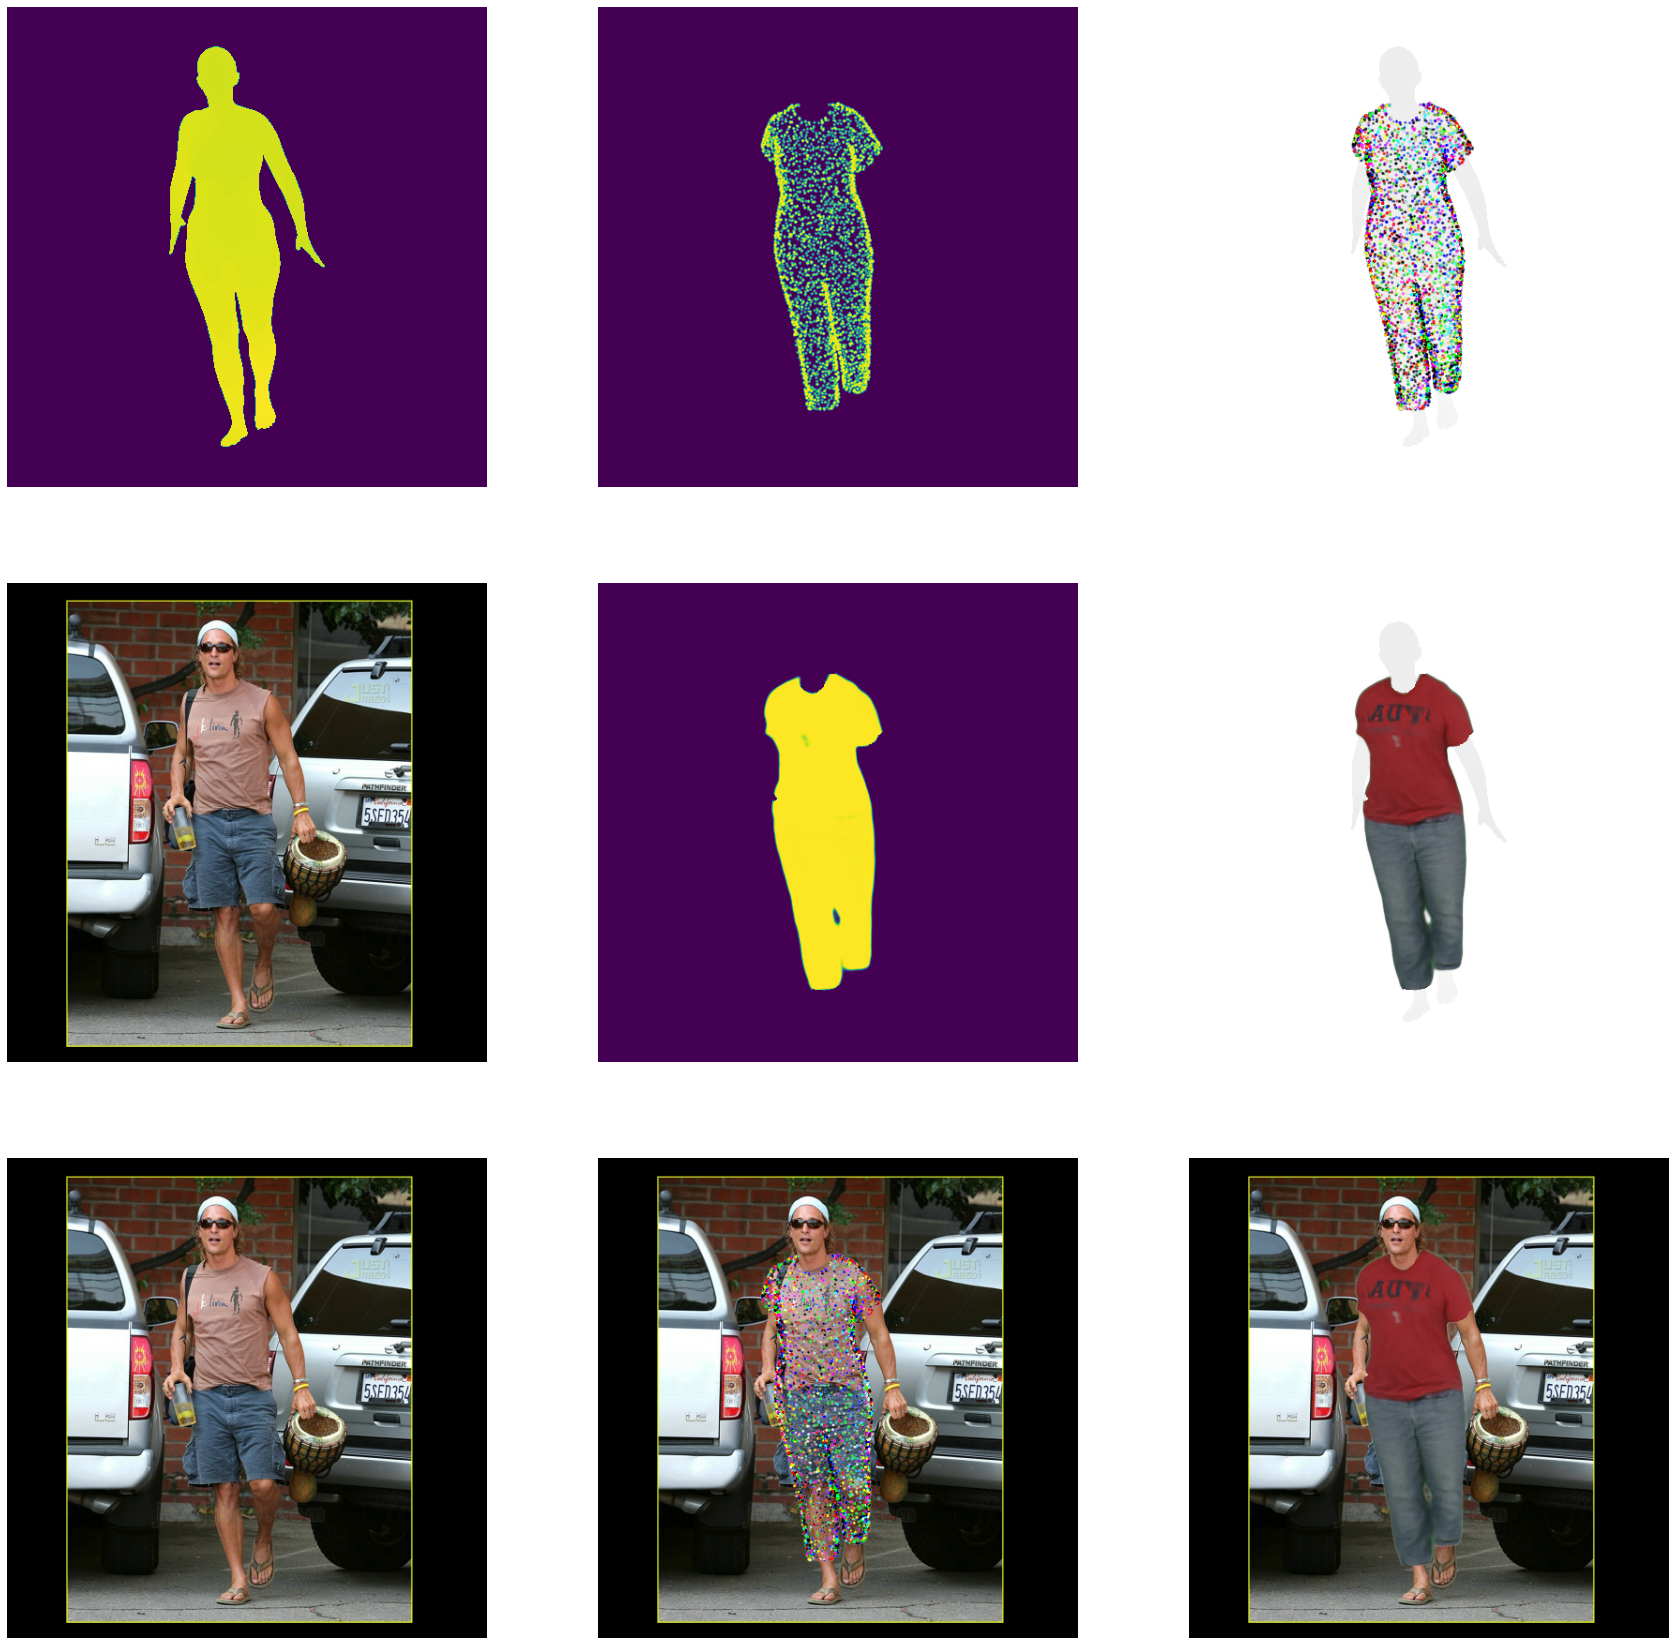

In [5]:
for i, (data_dict, target_dict) in enumerate(dataloader):
    data_dict = dict2device(data_dict, device)
    data_dict['cam'] = ''
    data_dict['seq'] = [style_pid]

    out_dict = infer_pid(style_pid, data_dict, target_dict, outfit_code, ndesc_stack, converter, 
                         draping_network, renderer, renderer_flood, generator, device=device, args=args)
    
    rgb_np, raster_features_np, real_rgb_np, real_segm_np, real_rgb_nos_np, vton_pcd_np, vton_rgb_np = to_img([
        out_dict['rgb_np'], out_dict['raster_features_np'], out_dict['real_rgb_np'], out_dict['real_segm_np'], 
        out_dict['real_rgb_nos_np'], out_dict['vton_pcd_np'], out_dict['vton_rgb_np']])

    show_axes([out_dict['smpl_rast'][0][0].cpu(), out_dict['raster_mask_np'], raster_features_np[..., ::-1],
               real_rgb_nos_np, out_dict['segm_np'], rgb_np,
               real_rgb_nos_np, vton_pcd_np, vton_rgb_np])
    
    # pid = data_dict['seq'][0]
    # frame = data_dict['fid'][0]
    # cv2.imwrite(f'out/appearance/{pid}_{frame}_rgb.png', rgb_np[..., ::-1])
    # cv2.imwrite(f'out/appearance/{pid}_{frame}_pcd.png', raster_features_np[..., ::-1])